<a href="https://colab.research.google.com/github/Qasim1507/BIPV_NEW/blob/main/SERIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load pre-trained models and scalers
# try:
#     model_si = joblib.load('model_si.pkl')
#     model_tandem_top = joblib.load('model_tandem_top.pkl')
#     model_tandem_bot = joblib.load('model_tandem_bot.pkl')
#     scaler_si = joblib.load('scaler_si.pkl')
#     scaler_tandem = joblib.load('scaler_tandem.pkl')
#     print("✅ Models loaded successfully!")
# except:
#     print("❌ Could not load models. Please ensure model files exist.")
#     # Create dummy models for demonstration
#     model_si = RandomForestRegressor()
#     model_tandem_top = RandomForestRegressor()
#     model_tandem_bot = RandomForestRegressor()
#     scaler_si = StandardScaler()
#     scaler_tandem = StandardScaler()

model_si = joblib.load('/content/drive/MyDrive/BIPV_NEW/model_si.pkl')
model_tandem_top = joblib.load('/content/drive/MyDrive/BIPV_NEW/model_tandem_top.pkl')
model_tandem_bot = joblib.load('/content/drive/MyDrive/BIPV_NEW/model_tandem_bot.pkl')
scaler_si = joblib.load('/content/drive/MyDrive/BIPV_NEW/scaler_si.pkl')
scaler_tandem = joblib.load('/content/drive/MyDrive/BIPV_NEW/scaler_tandem.pkl')
print("✅ Models loaded successfully!")

✅ Models loaded successfully!


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw  # Make sure ImageDraw is imported
import cv2
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')

def create_pointillism_image(image_path, opacity_level):
    """Create pointillism image with specified alpha channel opacity using simple dots"""

    # Parameters
    alpha_level = opacity_level  # Controls actual alpha (0.0-1.0)
    frame_width_mm = 400
    frame_height_mm = 400
    px_per_mm = 10

    # Simple dot configuration - no complex area calculations
    dot_diameter_mm = 1.5  # Fixed dot size
    dot_spacing_mm = 3.0   # Fixed spacing

    # Create processor with simple dots
    processor = SimplePointillizer(
        image_path=image_path,
        output_path="",
        dot_diameter_mm=dot_diameter_mm,
        dot_spacing_mm=dot_spacing_mm,
        alpha_level=alpha_level,
        frame_width_mm=frame_width_mm,
        frame_height_mm=frame_height_mm,
        px_per_mm=px_per_mm,
    )

    # Process image
    processor.load_and_resize_image()
    img = processor.process_and_draw(saving=False)

    return np.array(img)

class SimplePointillizer:
    def __init__(self, image_path, output_path, dot_diameter_mm=1.5, dot_spacing_mm=3.0,
                 alpha_level=1.0, frame_width_mm=400, frame_height_mm=400,
                 px_per_mm=12, cropping=True, background_color=None):
        self.image_path = image_path
        self.output_path = output_path
        self.frame_width_mm = frame_width_mm
        self.frame_height_mm = frame_height_mm
        self.px_per_mm = px_per_mm
        self.dot_diameter_mm = dot_diameter_mm
        self.dot_spacing_mm = dot_spacing_mm
        self.alpha_level = alpha_level
        self.cropping = cropping

        if not background_color is None:
            self.background = background_color
        else:
            self.background = (0, 0, 0, 0)

        self.dot_diameter_px = int(dot_diameter_mm * px_per_mm)
        self.dot_spacing_px = int(dot_spacing_mm * px_per_mm)

        # Calculate grid
        self.width_px = int(frame_width_mm * px_per_mm)
        self.height_px = int(frame_height_mm * px_per_mm)
        self.num_cols = self.width_px // self.dot_spacing_px
        self.num_rows = self.height_px // self.dot_spacing_px

        self.img_array = None
        self.processed_image = None

    def _cropImg(self, img):
        horiginal, woriginal = np.array(img).shape[:-1]
        aspectRatio = woriginal/horiginal
        desiredAR = self.frame_width_mm/self.frame_height_mm
        if desiredAR > aspectRatio:
            yMiddle = horiginal/2
            offset = 0.5*woriginal/desiredAR
            newDimensions = (0, yMiddle-offset, woriginal, yMiddle+offset)
        else:
            xMiddle = woriginal/2
            offset = 0.5*horiginal*desiredAR
            newDimensions = (xMiddle-offset, 0, xMiddle+offset, horiginal)
        return img.crop(newDimensions)

    def load_and_resize_image(self):
        img = Image.open(self.image_path).convert('RGB')
        # Resize to match frame dimensions
        target_size = (self.width_px, self.height_px)
        if self.cropping:
            img = self._cropImg(img)
        img = img.resize(target_size)
        self.processed_image = img.convert("RGBA")
        self.img_array = np.array(self.processed_image)

    def process_and_draw(self, saving=False):
        new_img = Image.new('RGBA', (self.width_px, self.height_px), self.background)
        draw = ImageDraw.Draw(new_img)  # This was missing the import

        for i in range(self.num_rows):
            for j in range(self.num_cols):
                # Calculate dot position
                x_center = j * self.dot_spacing_px + self.dot_spacing_px // 2
                y_center = i * self.dot_spacing_px + self.dot_spacing_px // 2

                # Get color from original image
                if (x_center < self.width_px and y_center < self.height_px and
                    x_center >= 0 and y_center >= 0):

                    # Sample color from a small area around the dot center
                    x_start = max(0, x_center - 2)
                    x_end = min(self.width_px, x_center + 2)
                    y_start = max(0, y_center - 2)
                    y_end = min(self.height_px, y_center + 2)

                    color_patch = self.img_array[y_start:y_end, x_start:x_end, :3]
                    if color_patch.size > 0:
                        mean_color = np.mean(color_patch.reshape(-1, 3), axis=0).astype('uint8')
                        r, g, b = mean_color

                        # Apply alpha transparency
                        rgba_color = (r, g, b, int(255 * self.alpha_level))

                        # Draw dot
                        radius = self.dot_diameter_px // 2
                        bbox = (x_center - radius, y_center - radius,
                               x_center + radius, y_center + radius)
                        draw.ellipse(bbox, fill=rgba_color)

        return new_img

# Also need to fix the evolutionary algorithm to handle errors properly
def evolutionary_algorithm_optimization(image_path, model_type="si", generations=10, population_size=8):
    """Evolutionary Algorithm to find optimal opacity level"""
    print("🚀 Starting Evolutionary Algorithm for opacity optimization...")

    # Initialize population
    population = np.random.uniform(0.1, 0.9, population_size)
    best_opacity = 0.5
    best_current = 0

    # Store results for analysis
    results = []

    for generation in range(generations):
        print(f"\nGeneration {generation + 1}/{generations}")
        generation_results = []

        for i, opacity in enumerate(population):
            try:
                # Create pointillism image with current opacity
                pointillism_img = create_pointillism_image(image_path, opacity)

                # Predict current - need to handle case where prediction fails
                current = predict_current_from_array(pointillism_img, model_type)
                generation_results.append((opacity, current))

                print(f"  Individual {i+1}: opacity={opacity:.3f}, current={current:.3f} mA/cm²")

                # Update best solution
                if current > best_current:
                    best_current = current
                    best_opacity = opacity

            except Exception as e:
                print(f"  Error with opacity {opacity:.3f}: {str(e)}")
                # Assign a very low current for failed cases
                generation_results.append((opacity, -1000))

        results.extend(generation_results)

        # Selection: Keep best individuals
        generation_results.sort(key=lambda x: x[1], reverse=True)
        best_individuals = generation_results[:population_size//2]

        # Crossover and Mutation
        new_population = [ind[0] for ind in best_individuals]  # Elitism

        while len(new_population) < population_size:
            # Select parents from best individuals
            parent1, parent2 = np.random.choice([ind[0] for ind in best_individuals], 2, replace=False)

            # Crossover (average)
            child = (parent1 + parent2) / 2

            # Mutation
            mutation = np.random.normal(0, 0.1)
            child = np.clip(child + mutation, 0.1, 0.9)

            new_population.append(child)

        population = np.array(new_population)

    # Filter out failed results
    valid_results = [(op, curr) for op, curr in results if curr > -1000]

    if not valid_results:
        print("❌ No valid results found! Using default values.")
        best_opacity = 0.5
        best_current = 0
        target_current = 0
        optimal_opacity = 0.5
    else:
        # Find opacity with 20% loss from max current
        target_current = best_current * 0.8
        optimal_opacity = best_opacity
        min_diff = float('inf')

        for opacity, current in valid_results:
            diff = abs(current - target_current)
            if diff < min_diff and current >= target_current:
                min_diff = diff
                optimal_opacity = opacity

    print(f"\n🎯 Optimization Complete!")
    print(f"Best opacity: {best_opacity:.3f} (Current: {best_current:.3f} mA/cm²)")
    print(f"Optimal opacity with 20% loss: {optimal_opacity:.3f}")
    print(f"Target current: {target_current:.3f} mA/cm²")

    return optimal_opacity, best_current, results

# Make sure predict_current_from_array is defined
def predict_current_from_array(image_array, model_type="si"):
    """Predict current density from image array"""
    try:
        # Convert array to PIL Image and then to RGBA
        img = Image.fromarray(image_array).convert("RGBA")
        img_array = np.array(img)
        h, w, _ = img_array.shape

        # Reshape into (n_pixels, 4)
        pixels = img_array.reshape(-1, 4)
        pixel_df = pd.DataFrame(pixels, columns=['R', 'G', 'B', 'A'])

        # Predict
        if model_type.lower() == "si":
            X_scaled = scaler_si.transform(pixel_df)
            jph_preds = model_si.predict(X_scaled)
            return np.mean(jph_preds)

        elif model_type.lower() == "tandem":
            X_scaled = scaler_tandem.transform(pixel_df)
            jph_top = model_tandem_top.predict(X_scaled)
            jph_bot = model_tandem_bot.predict(X_scaled)
            jph_limiting = np.minimum(jph_top, jph_bot)
            return np.mean(jph_limiting)

        else:
            raise ValueError("Invalid model_type. Use 'si' or 'tandem'.")
    except Exception as e:
        print(f"Prediction error: {e}")
        return 0.0  # Return 0 if prediction fails

In [13]:
def predict_current_from_array(image_array, model_type="si"):
    """Predict current density from image array"""
    # Convert array to PIL Image and then to RGBA
    img = Image.fromarray(image_array).convert("RGBA")
    img_array = np.array(img)
    h, w, _ = img_array.shape

    # Reshape into (n_pixels, 4)
    pixels = img_array.reshape(-1, 4)
    pixel_df = pd.DataFrame(pixels, columns=['R', 'G', 'B', 'A'])

    # Predict
    if model_type.lower() == "si":
        X_scaled = scaler_si.transform(pixel_df)
        jph_preds = model_si.predict(X_scaled)
        return np.mean(jph_preds)

    elif model_type.lower() == "tandem":
        X_scaled = scaler_tandem.transform(pixel_df)
        jph_top = model_tandem_top.predict(X_scaled)
        jph_bot = model_tandem_bot.predict(X_scaled)
        jph_limiting = np.minimum(jph_top, jph_bot)
        return np.mean(jph_limiting)

    else:
        raise ValueError("Invalid model_type. Use 'si' or 'tandem'.")

In [14]:
def evolutionary_algorithm_optimization(image_path, model_type="si", generations=10, population_size=8):
    """Evolutionary Algorithm to find optimal opacity level"""
    print("🚀 Starting Evolutionary Algorithm for opacity optimization...")

    # Initialize population
    population = np.random.uniform(0.1, 0.9, population_size)
    best_opacity = 0.5
    best_current = 0

    # Store results for analysis
    results = []

    for generation in range(generations):
        print(f"\nGeneration {generation + 1}/{generations}")
        generation_results = []

        for i, opacity in enumerate(population):
            try:
                # Create pointillism image with current opacity
                pointillism_img = create_pointillism_image(image_path, opacity)

                # Predict current
                current = predict_current_from_array(pointillism_img, model_type)
                generation_results.append((opacity, current))

                print(f"  Individual {i+1}: opacity={opacity:.3f}, current={current:.3f} mA/cm²")

                # Update best solution
                if current > best_current:
                    best_current = current
                    best_opacity = opacity

            except Exception as e:
                print(f"  Error with opacity {opacity}: {e}")
                generation_results.append((opacity, 0))

        results.extend(generation_results)

        # Selection: Keep best individuals
        generation_results.sort(key=lambda x: x[1], reverse=True)
        best_individuals = generation_results[:population_size//2]

        # Crossover and Mutation
        new_population = [ind[0] for ind in best_individuals]  # Elitism

        while len(new_population) < population_size:
            # Select parents from best individuals
            parent1, parent2 = np.random.choice([ind[0] for ind in best_individuals], 2, replace=False)

            # Crossover (average)
            child = (parent1 + parent2) / 2

            # Mutation
            mutation = np.random.normal(0, 0.1)
            child = np.clip(child + mutation, 0.1, 0.9)

            new_population.append(child)

        population = np.array(new_population)

    # Find opacity with 20% loss from max current
    target_current = best_current * 0.8
    optimal_opacity = best_opacity
    min_diff = float('inf')

    for opacity, current in results:
        diff = abs(current - target_current)
        if diff < min_diff and current >= target_current:
            min_diff = diff
            optimal_opacity = opacity

    print(f"\n🎯 Optimization Complete!")
    print(f"Best opacity: {best_opacity:.3f} (Current: {best_current:.3f} mA/cm²)")
    print(f"Optimal opacity with 20% loss: {optimal_opacity:.3f}")
    print(f"Target current: {target_current:.3f} mA/cm²")

    return optimal_opacity, best_current, results

In [15]:
def split_image_into_cells(image_array, n_cells):
    """Split image into n x n grid of solar cells"""
    h, w, _ = image_array.shape

    # Calculate grid dimensions
    cells_per_side = int(np.sqrt(n_cells))
    if cells_per_side ** 2 != n_cells:
        print(f"⚠️ Warning: {n_cells} is not a perfect square. Using {cells_per_side**2} cells instead.")
        n_cells = cells_per_side ** 2

    cell_height = h // cells_per_side
    cell_width = w // cells_per_side

    cells = []
    positions = []

    for i in range(cells_per_side):
        for j in range(cells_per_side):
            y_start = i * cell_height
            y_end = (i + 1) * cell_height
            x_start = j * cell_width
            x_end = (j + 1) * cell_width

            cell = image_array[y_start:y_end, x_start:x_end]
            cells.append(cell)
            positions.append((i, j))

    return cells, positions, cells_per_side

In [16]:
def analyze_solar_cells(image_path, optimal_opacity, n_cells, model_type="si"):
    """Analyze current density for each solar cell"""
    print(f"\n🔬 Analyzing {n_cells} solar cells with opacity {optimal_opacity:.3f}...")

    # Create pointillism image with optimal opacity
    pointillism_img = create_pointillism_image(image_path, optimal_opacity)

    # Split into cells
    cells, positions, grid_size = split_image_into_cells(pointillism_img, n_cells)

    # Calculate current density for each cell
    cell_currents = []
    for i, cell in enumerate(cells):
        current = predict_current_from_array(cell, model_type)
        cell_currents.append(current)
        print(f"  Cell {i+1} (row {positions[i][0]}, col {positions[i][1]}): {current:.3f} mA/cm²")

    # Create current density matrix
    current_matrix = np.zeros((grid_size, grid_size))
    for (row, col), current in zip(positions, cell_currents):
        current_matrix[row, col] = current

    return cell_currents, current_matrix, grid_size, pointillism_img, positions  # Added positions to return

In [17]:
def equalize_currents(cell_currents, method="lowest"):
    """Equalize currents to match the specified method"""
    if method == "lowest":
        target_current = min(cell_currents)
    elif method == "average":
        target_current = np.mean(cell_currents)
    else:
        raise ValueError("Method must be 'lowest' or 'average'")

    equalized_currents = [target_current] * len(cell_currents)

    print(f"\n⚡ Current equalization ({method} method):")
    print(f"Target current: {target_current:.3f} mA/cm²")
    print(f"Original current range: {min(cell_currents):.3f} - {max(cell_currents):.3f} mA/cm²")
    print(f"Equalized all cells to: {target_current:.3f} mA/cm²")

    return equalized_currents, target_current

=== Solar Cell Current Density Analysis ===
Image: /content/drive/MyDrive/BIPV_NEW/CJ.png
Model: si
Number of cells: 9

🚀 Starting Evolutionary Algorithm for opacity optimization...

Generation 1/8
  Individual 1: opacity=0.485, current=27.053 mA/cm²
  Individual 2: opacity=0.895, current=25.081 mA/cm²
  Individual 3: opacity=0.593, current=25.764 mA/cm²
  Individual 4: opacity=0.591, current=25.779 mA/cm²
  Individual 5: opacity=0.860, current=25.169 mA/cm²
  Individual 6: opacity=0.863, current=25.169 mA/cm²

Generation 2/8
  Individual 1: opacity=0.485, current=27.053 mA/cm²
  Individual 2: opacity=0.591, current=25.779 mA/cm²
  Individual 3: opacity=0.593, current=25.764 mA/cm²
  Individual 4: opacity=0.658, current=25.644 mA/cm²
  Individual 5: opacity=0.734, current=25.415 mA/cm²
  Individual 6: opacity=0.425, current=27.247 mA/cm²

Generation 3/8
  Individual 1: opacity=0.425, current=27.247 mA/cm²
  Individual 2: opacity=0.485, current=27.053 mA/cm²
  Individual 3: opacity=0.59

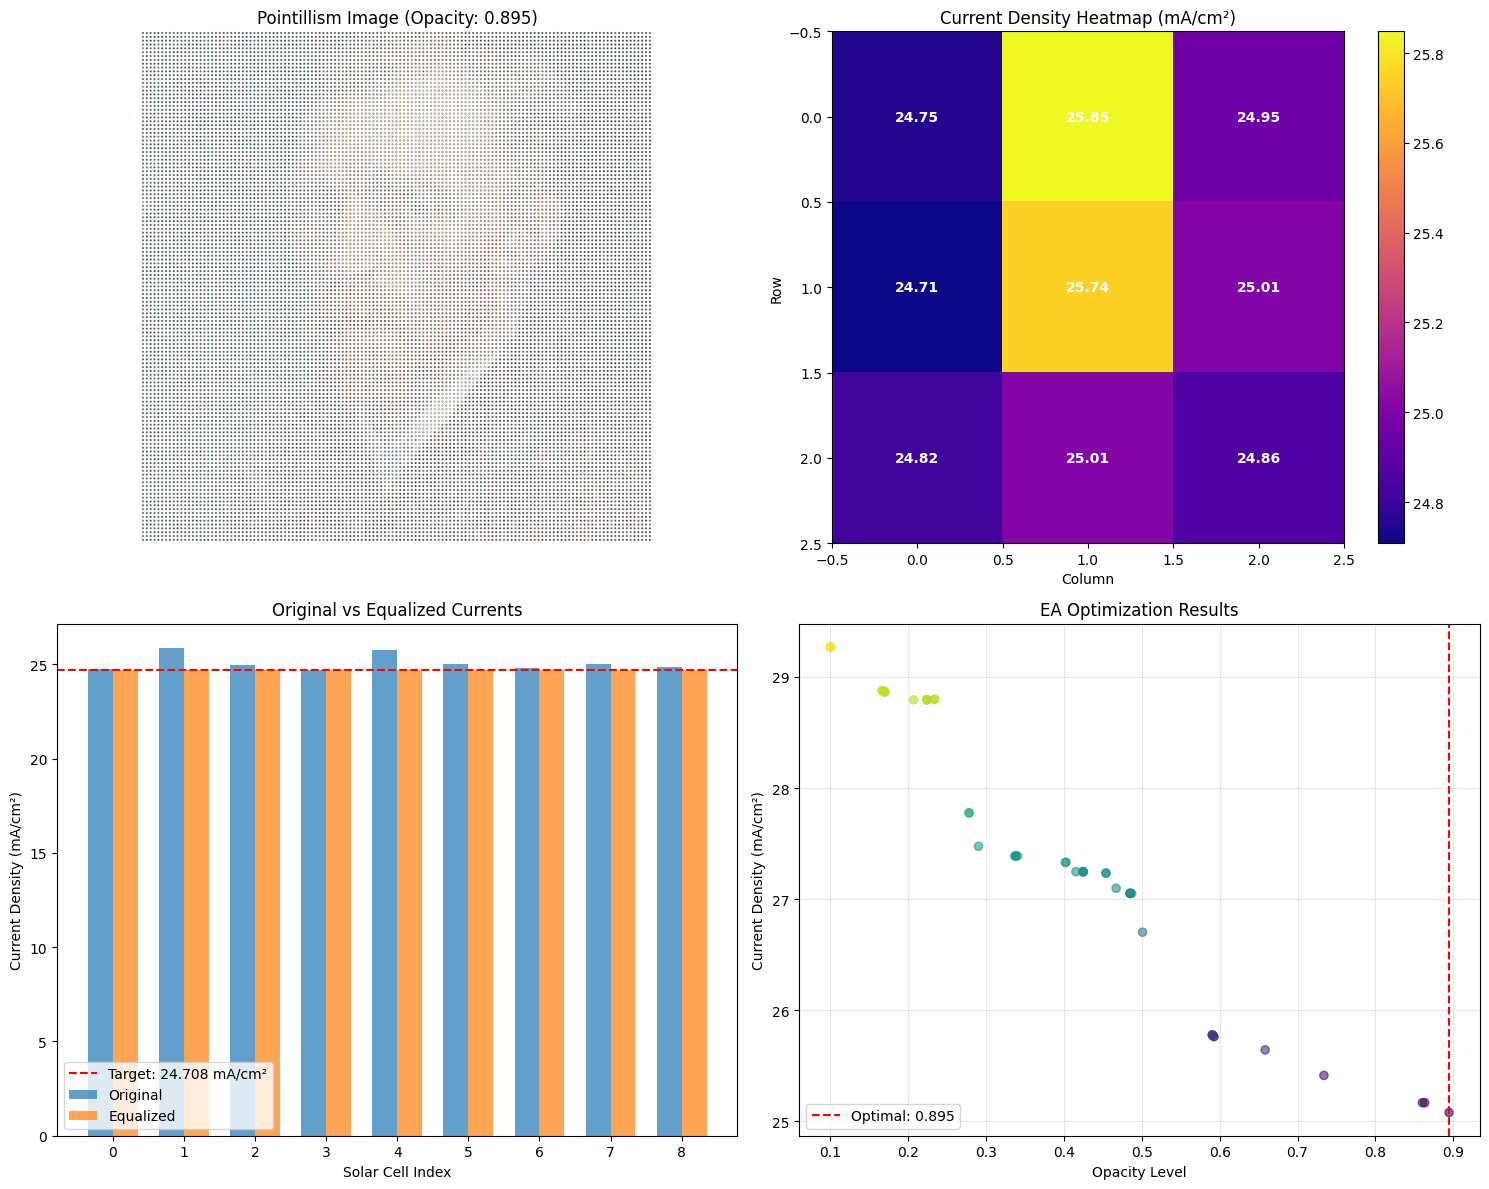


📈 SUMMARY STATISTICS
Optimal opacity level: 0.895
Maximum current density: 29.268 mA/cm²
Target current (20% loss): 23.415 mA/cm²
Number of solar cells: 9
Grid configuration: 3 × 3
Original current statistics:
  - Mean: 25.079 mA/cm²
  - Std: 0.397 mA/cm²
  - Min: 24.708 mA/cm²
  - Max: 25.848 mA/cm²
Equalized current: 24.708 mA/cm²

💾 Results saved to 'solar_cell_analysis_results.csv'


In [18]:
# Main execution
if __name__ == "__main__":
    # Configuration
    IMAGE_PATH = "/content/drive/MyDrive/BIPV_NEW/CJ.png"  # Replace with your image path
    MODEL_TYPE = "si"  # "si" or "tandem"
    N_CELLS = 9  # Number of solar cells (should be perfect square: 4, 9, 16, 25, etc.)

    print("=== Solar Cell Current Density Analysis ===")
    print(f"Image: {IMAGE_PATH}")
    print(f"Model: {MODEL_TYPE}")
    print(f"Number of cells: {N_CELLS}")

    # Step 1: Find optimal opacity using Evolutionary Algorithm
    print("\n" + "="*50)
    optimal_opacity, max_current, ea_results = evolutionary_algorithm_optimization(
        IMAGE_PATH, MODEL_TYPE, generations=8, population_size=6
    )

    # Step 2: Split image into solar cells and analyze current densities
    print("\n" + "="*50)
    cell_currents, current_matrix, grid_size, processed_img, positions = analyze_solar_cells(
        IMAGE_PATH, optimal_opacity, N_CELLS, MODEL_TYPE
    )

    # Step 3: Equalize currents to match the lowest cell
    print("\n" + "="*50)
    equalized_currents, target_current = equalize_currents(cell_currents, method="lowest")

    # Visualization
    print("\n" + "="*50)
    print("📊 Generating visualizations...")

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Original pointillism image
    axes[0, 0].imshow(processed_img)
    axes[0, 0].set_title(f'Pointillism Image (Opacity: {optimal_opacity:.3f})')
    axes[0, 0].axis('off')

    # Plot 2: Current density heatmap
    im = axes[0, 1].imshow(current_matrix, cmap='plasma', aspect='equal')
    axes[0, 1].set_title('Current Density Heatmap (mA/cm²)')
    axes[0, 1].set_xlabel('Column')
    axes[0, 1].set_ylabel('Row')

    # Add values to heatmap
    for i in range(grid_size):
        for j in range(grid_size):
            axes[0, 1].text(j, i, f'{current_matrix[i, j]:.2f}',
                           ha='center', va='center', color='white', fontweight='bold')

    plt.colorbar(im, ax=axes[0, 1])

    # Plot 3: Original vs Equalized currents
    x_pos = np.arange(len(cell_currents))
    width = 0.35

    axes[1, 0].bar(x_pos - width/2, cell_currents, width, label='Original', alpha=0.7)
    axes[1, 0].bar(x_pos + width/2, equalized_currents, width, label='Equalized', alpha=0.7)
    axes[1, 0].axhline(y=target_current, color='r', linestyle='--', label=f'Target: {target_current:.3f} mA/cm²')
    axes[1, 0].set_xlabel('Solar Cell Index')
    axes[1, 0].set_ylabel('Current Density (mA/cm²)')
    axes[1, 0].set_title('Original vs Equalized Currents')
    axes[1, 0].legend()
    axes[1, 0].set_xticks(x_pos)

    # Plot 4: EA optimization progress
    opacities, currents = zip(*ea_results)
    axes[1, 1].scatter(opacities, currents, alpha=0.6, c=currents, cmap='viridis')
    axes[1, 1].axvline(x=optimal_opacity, color='red', linestyle='--', label=f'Optimal: {optimal_opacity:.3f}')
    axes[1, 1].set_xlabel('Opacity Level')
    axes[1, 1].set_ylabel('Current Density (mA/cm²)')
    axes[1, 1].set_title('EA Optimization Results')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\n" + "="*50)
    print("📈 SUMMARY STATISTICS")
    print(f"Optimal opacity level: {optimal_opacity:.3f}")
    print(f"Maximum current density: {max_current:.3f} mA/cm²")
    print(f"Target current (20% loss): {max_current * 0.8:.3f} mA/cm²")
    print(f"Number of solar cells: {N_CELLS}")
    print(f"Grid configuration: {grid_size} × {grid_size}")
    print(f"Original current statistics:")
    print(f"  - Mean: {np.mean(cell_currents):.3f} mA/cm²")
    print(f"  - Std: {np.std(cell_currents):.3f} mA/cm²")
    print(f"  - Min: {np.min(cell_currents):.3f} mA/cm²")
    print(f"  - Max: {np.max(cell_currents):.3f} mA/cm²")
    print(f"Equalized current: {target_current:.3f} mA/cm²")

    # Save results - NOW positions is defined
    results_df = pd.DataFrame({
        'Cell_Index': range(1, len(cell_currents) + 1),
        'Row': [pos[0] for pos in positions],
        'Column': [pos[1] for pos in positions],
        'Original_Current': cell_currents,
        'Equalized_Current': equalized_currents
    })

    results_df.to_csv('solar_cell_analysis_results.csv', index=False)
    print(f"\n💾 Results saved to 'solar_cell_analysis_results.csv'")

In [19]:
# Save the final optimized pointillism image
final_opacity = optimal_opacity  # From EA optimization
final_pointillism_img = create_pointillism_image(IMAGE_PATH, final_opacity)

# Save with meaningful filename
final_output_file = f"optimized_pointillism_opacity_{final_opacity:.3f}.png"
plt.figure(figsize=(12, 12))
plt.imshow(final_pointillism_img)
plt.axis('off')
plt.savefig(final_output_file, dpi=300, bbox_inches='tight', pad_inches=0,
            facecolor='none', transparent=True)
plt.close()

print(f"💾 Final optimized pointillism image saved as: {final_output_file}")
print(f"📊 Optimal opacity: {final_opacity:.3f}")
print(f"⚡ Maximum current: {max_current:.3f} mA/cm²")

💾 Final optimized pointillism image saved as: optimized_pointillism_opacity_0.895.png
📊 Optimal opacity: 0.895
⚡ Maximum current: 29.268 mA/cm²


In [24]:
def validate_results(results_df, cell_currents, optimal_opacity, max_current):
    """Comprehensive validation of analysis results"""

    print("🔍 VALIDATION RESULTS")
    print("=" * 50)

    # 1. Check data completeness
    print("1. Data Completeness:")
    print(f"   - Results DataFrame shape: {results_df.shape}")
    print(f"   - Expected rows: {len(cell_currents)}")
    print(f"   - Missing values: {results_df.isnull().sum().sum()}")

    # 2. Check current density ranges
    print("\n2. Current Density Validation:")
    print(f"   - Original currents range: {np.min(cell_currents):.3f} to {np.max(cell_currents):.3f} mA/cm²")
    print(f"   - Max current achieved: {max_current:.3f} mA/cm²")
    print(f"   - Optimal opacity: {optimal_opacity:.3f}")

    # 3. Check for physical plausibility
    print("\n3. Physical Plausibility:")
    if max_current > 50:  # Adjust based on your expected range
        print("   ⚠️  Warning: Very high current density detected")
    elif max_current < 0.1:
        print("   ⚠️  Warning: Very low current density detected")
    else:
        print("   ✓ Current densities within reasonable range")

    # 4. Check equalization effectiveness
    print("\n4. Equalization Analysis:")
    original_std = np.std(cell_currents)
    equalized_std = np.std(results_df['Equalized_Current'])
    improvement = ((original_std - equalized_std) / original_std) * 100
    print(f"   - Original std: {original_std:.3f}")
    print(f"   - Equalized std: {equalized_std:.3f}")
    print(f"   - Improvement: {improvement:.1f}%")

    # 5. Check CSV file
    try:
        saved_df = pd.read_csv('solar_cell_analysis_results.csv')
        print(f"\n5. File Output:")
        print(f"   ✓ CSV file saved successfully")
        print(f"   - File shape: {saved_df.shape}")
        print(f"   - Columns: {list(saved_df.columns)}")
    except:
        print("   ❌ CSV file not found or corrupted")

In [35]:
def validate_image_processing(image_path, opacity_levels=[0.2, 0.5, 0.8]):
    """Validate that image processing works across different opacity levels"""
    print("🖼️ IMAGE PROCESSING VALIDATION")
    print("=" * 50)

    fig, axes = plt.subplots(1, len(opacity_levels), figsize=(15, 5))

    for i, opacity in enumerate(opacity_levels):
        try:
            processed_img = create_pointillism_image(image_path, opacity)
            axes[i].imshow(processed_img)
            axes[i].set_title(f'Opacity: {opacity}\nShape: {processed_img.shape}')
            axes[i].axis('off')
            print(f"✓ Opacity {opacity}: Success - Shape {processed_img.shape}")
        except Exception as e:
            print(f"❌ Opacity {opacity}: Failed - {e}")
            axes[i].text(0.5, 0.5, f'Failed\n{str(e)}',
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [37]:
def create_validation_plots(results_df, cell_currents, equalized_currents, current_matrix):
    """Create additional validation visualizations"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Distribution of currents
    axes[0, 0].hist(cell_currents, bins=10, alpha=0.7, color='blue', label='Original')
    axes[0, 0].axvline(np.mean(cell_currents), color='red', linestyle='--', label=f'Mean: {np.mean(cell_currents):.2f}')
    axes[0, 0].set_xlabel('Current Density (mA/cm²)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Cell Currents')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Spatial distribution heatmap
    im = axes[0, 1].imshow(current_matrix, cmap='YlOrRd', aspect='equal')
    axes[0, 1].set_title('Spatial Current Distribution')
    axes[0, 1].set_xlabel('Column')
    axes[0, 1].set_ylabel('Row')

    # Add values to heatmap
    for i in range(current_matrix.shape[0]):
        for j in range(current_matrix.shape[1]):
            axes[0, 1].text(j, i, f'{current_matrix[i, j]:.2f}',
                           ha='center', va='center', color='black', fontsize=8)
    plt.colorbar(im, ax=axes[0, 1])

    # 3. Current variation by position
    positions = list(range(1, len(cell_currents) + 1))
    axes[1, 0].plot(positions, cell_currents, 'o-', label='Original', alpha=0.7)
    axes[1, 0].plot(positions, equalized_currents, 's-', label='Equalized', alpha=0.7)
    axes[1, 0].set_xlabel('Cell Position')
    axes[1, 0].set_ylabel('Current Density (mA/cm²)')
    axes[1, 0].set_title('Current Variation Across Cells')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Statistical summary
    stats_data = {
        'Metric': ['Mean', 'Std Dev', 'Min', 'Max', 'Range'],
        'Original': [f'{np.mean(cell_currents):.3f}', f'{np.std(cell_currents):.3f}',
                    f'{np.min(cell_currents):.3f}', f'{np.max(cell_currents):.3f}',
                    f'{np.max(cell_currents)-np.min(cell_currents):.3f}'],
        'Equalized': [f'{np.mean(equalized_currents):.3f}', f'{np.std(equalized_currents):.3f}',
                     f'{np.min(equalized_currents):.3f}', f'{np.max(equalized_currents):.3f}',
                     f'{np.max(equalized_currents)-np.min(equalized_currents):.3f}']
    }

    stats_df = pd.DataFrame(stats_data)
    axes[1, 1].axis('off')
    table = axes[1, 1].table(cellText=stats_df.values,
                            colLabels=stats_df.columns,
                            cellLoc='center',
                            loc='center',
                            bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    axes[1, 1].set_title('Statistical Summary')

    plt.tight_layout()
    plt.show()


🚀 RUNNING COMPLETE VALIDATION SUITE
🔍 VALIDATION RESULTS
1. Data Completeness:
   - Results DataFrame shape: (9, 5)
   - Expected rows: 9
   - Missing values: 0

2. Current Density Validation:
   - Original currents range: 24.708 to 25.848 mA/cm²
   - Max current achieved: 29.268 mA/cm²
   - Optimal opacity: 0.895

3. Physical Plausibility:
   ✓ Current densities within reasonable range

4. Equalization Analysis:
   - Original std: 0.397
   - Equalized std: 0.000
   - Improvement: 100.0%

5. File Output:
   ✓ CSV file saved successfully
   - File shape: (9, 5)
   - Columns: ['Cell_Index', 'Row', 'Column', 'Original_Current', 'Equalized_Current']

🖼️ IMAGE PROCESSING VALIDATION
✓ Opacity 0.2: Success - Shape (4000, 4000, 4)
✓ Opacity 0.5: Success - Shape (4000, 4000, 4)
✓ Opacity 0.8: Success - Shape (4000, 4000, 4)


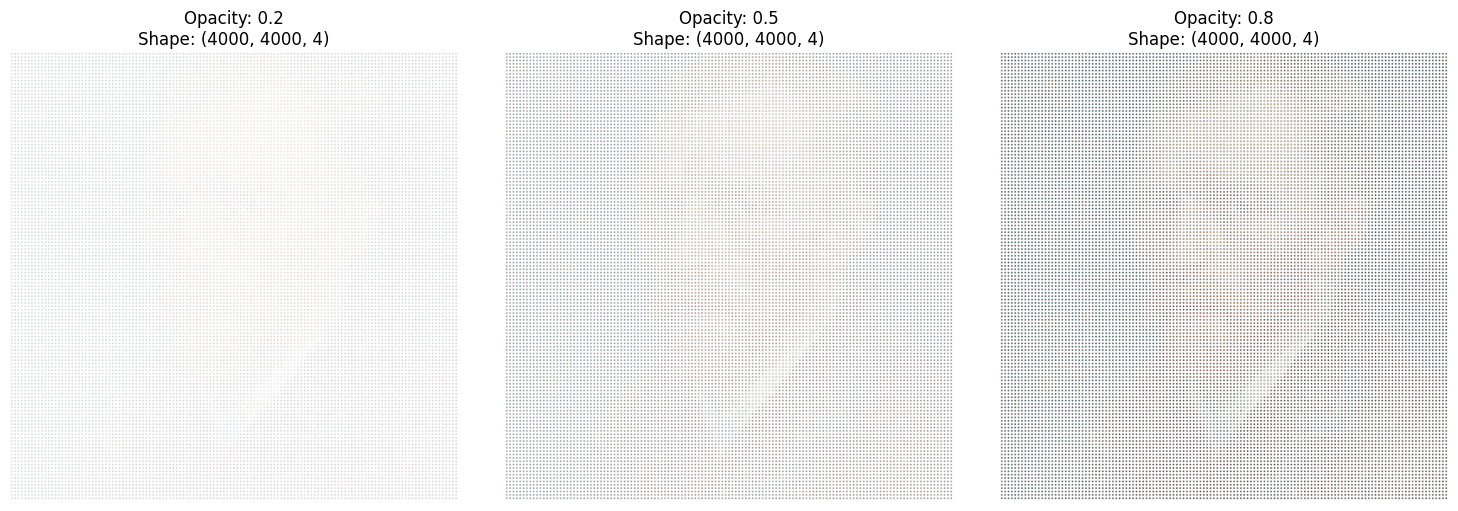

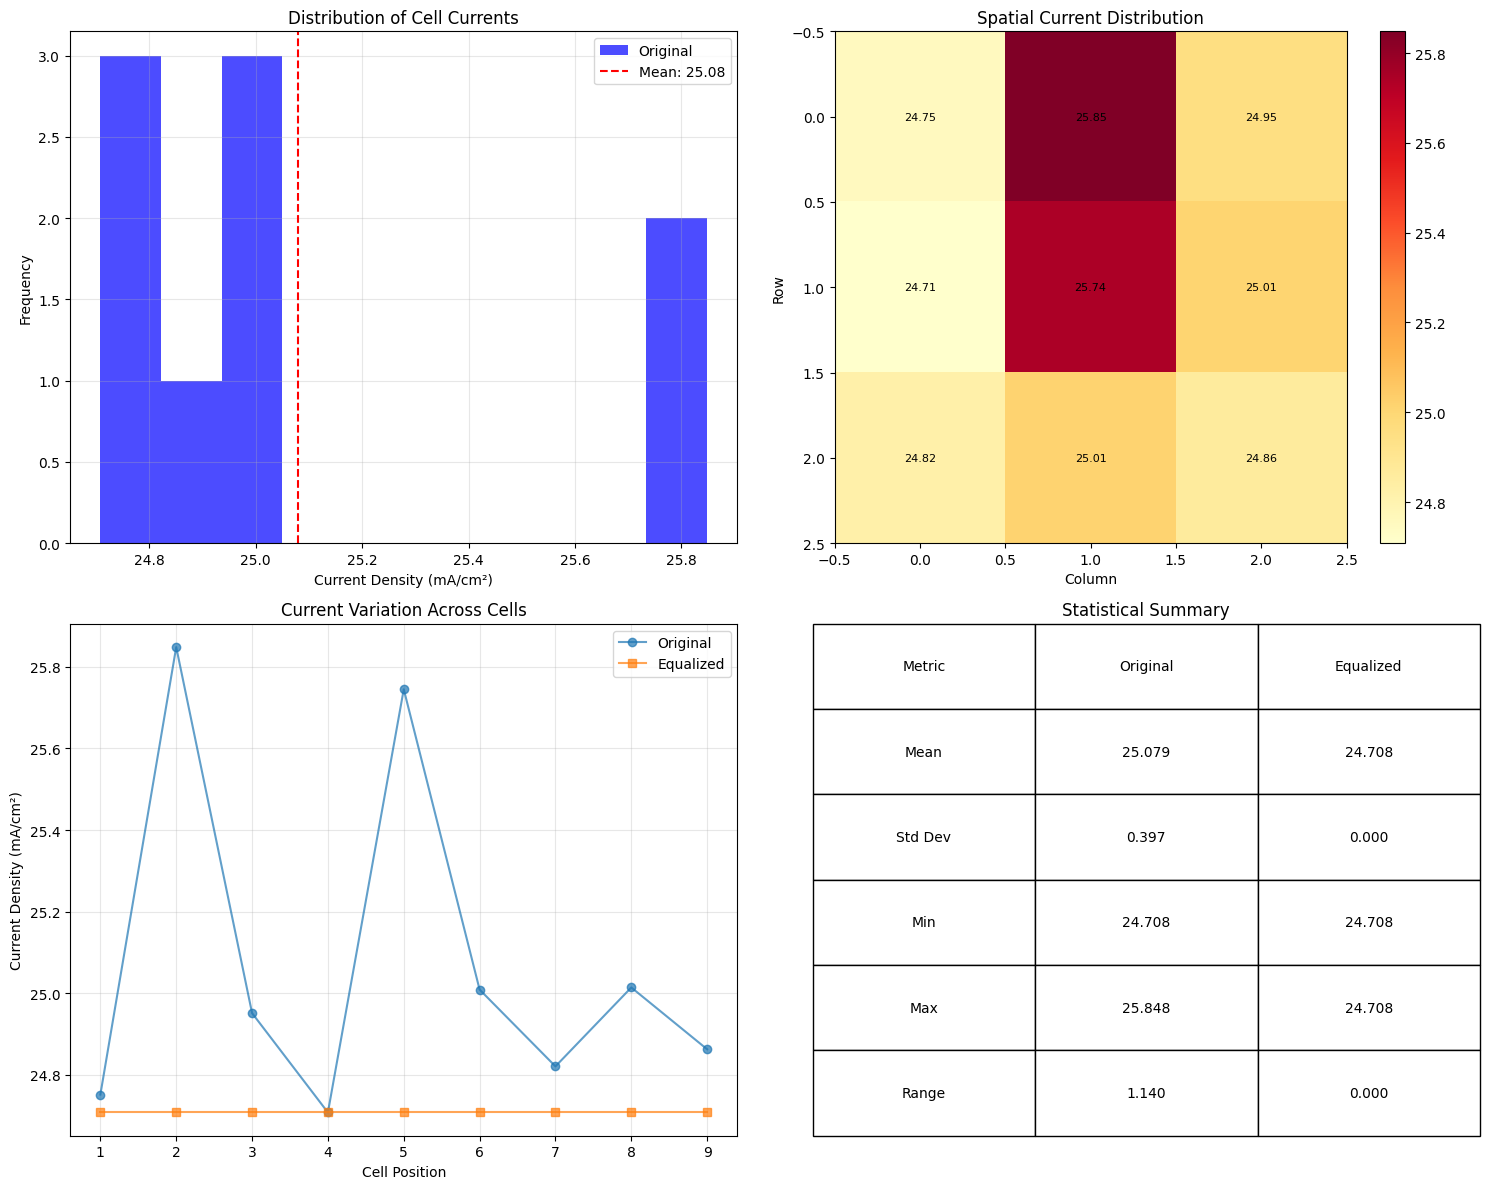

✅ VALIDATION COMPLETE


In [38]:
def run_complete_validation(image_path, results_df, cell_currents, equalized_currents,
                           current_matrix, optimal_opacity, max_current):
    """Run all validation checks"""

    print("🚀 RUNNING COMPLETE VALIDATION SUITE")
    print("=" * 60)

    # 1. Data validation
    validate_results(results_df, cell_currents, optimal_opacity, max_current)

    print("\n" + "=" * 60)

    # 3. Image processing validation
    validate_image_processing(image_path)

    print("\n" + "=" * 60)

    # 4. Visual validation
    create_validation_plots(results_df, cell_currents, equalized_currents, current_matrix)

    print("✅ VALIDATION COMPLETE")

# Run complete validation at the end of your notebook
run_complete_validation(IMAGE_PATH, results_df, cell_currents, equalized_currents,
                       current_matrix, optimal_opacity, max_current)